# Stock Price Prediction

### Datasets:
- To build the stock price prediction model, the NSE TATA GLOBAL dataset will be used. This is a dataset of Tata Beverages from Tata Global Beverages Limited, National Stock Exchange of India: Tata Global Dataset

- To develop the dashboard for stock analysis will be used another stock dataset with multiple stocks like Apple, Microsoft, Facebook: Stocks Dataset

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import shapiro
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Import data
df = pd.read_csv("NSE-Tata-Global-Beverages-Limited.csv")
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


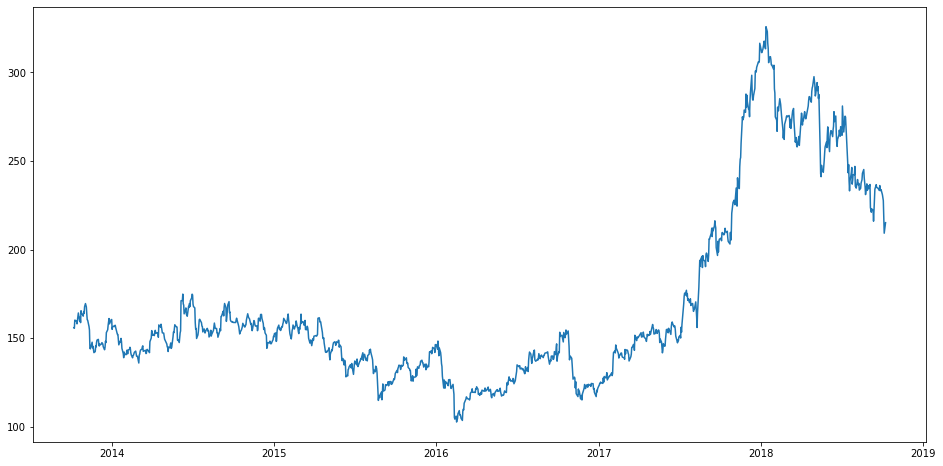

In [4]:
# Analyze the target variable - stock close price

df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']

plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')

In [10]:
# Normality Test - Shapiro-Wilk test

data = df['Close']

def normality_test(data):
    stat, p = shapiro(data)
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('Probably Gaussian')
    else:
        print('Probably not Gaussian')
        
# Stationarity - Augmented Dickey-Fuller test

def stationarity_test(data):
    stat, p, lags, obs, crit, t = adfuller(data)
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('Probably not Stationary')
    else:
        print('Probably Stationary')

normality_test(data)
stationarity_test(data)

stat=0.795, p=0.000
Probably not Gaussian
stat=-1.325, p=0.618
Probably not Stationary


In [111]:
# Sort dataset
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]

_____________________________

## Modeling

In [112]:
# Normalization
scaler=MinMaxScaler(feature_range=(0,1))
final_dataset_close=new_dataset[['Close']]
final_dataset_date=new_dataset['Date'].values

new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset_close)

scaled_data=np.reshape(scaled_data,(scaled_data.shape[0],1))
final_dataset_date=np.reshape(final_dataset_date,(final_dataset_date.shape[0],1))
final_dataset = np.concatenate((final_dataset_date, scaled_data),axis=1)


# Train-test Split
x_train_data,y_train_data=[],[]

train_data=final_dataset[0:987,:]
valid_data=final_dataset[987:,:]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

In [126]:
# Build model

def build_model(x_train_data,new_dataset,valid_data):
    
    lstm_model=Sequential()
    lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
    lstm_model.add(LSTM(units=50))
    lstm_model.add(Dense(1))

    inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
    inputs_data=inputs_data.reshape(-1,1)
    inputs_data=scaler.transform(inputs_data)

    lstm_model.compile(loss='mean_squared_error',optimizer='adam')
    lstm_model.fit(x_train_data,y_train_data,epochs=10,batch_size=60,verbose=2)
    
    lstm_model.save("saved_model.h5")
    
    return lstm_model,inputs_data

In [128]:
lstm_model,inputs_data = build_model(x_train_data,new_dataset,valid_data)

Epoch 1/10
 - 3s - loss: 0.0093
Epoch 2/10
 - 1s - loss: 0.0021
Epoch 3/10
 - 1s - loss: 0.0011
Epoch 4/10
 - 1s - loss: 8.0158e-04
Epoch 5/10
 - 1s - loss: 8.2826e-04
Epoch 6/10
 - 1s - loss: 7.9115e-04
Epoch 7/10
 - 1s - loss: 7.4568e-04
Epoch 8/10
 - 1s - loss: 7.0542e-04
Epoch 9/10
 - 1s - loss: 6.9642e-04
Epoch 10/10
 - 1s - loss: 6.7719e-04


In [131]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

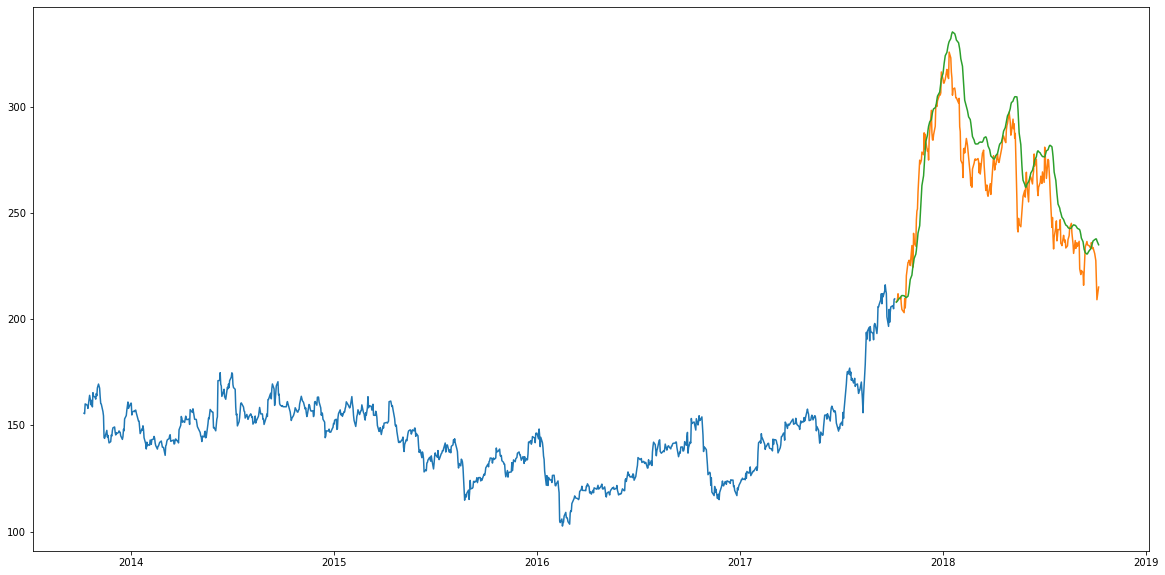

In [133]:
train_data=new_dataset[:987]
valid_data=new_dataset[987:]
valid_data['Predictions']=predicted_closing_price

# Calculate MAPE
valid_data['APE'] = (abs(valid_data['Close'] - valid_data['Predictions'])/valid_data['Close'])*100
valid_data['APE'].mean()

plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])

4.841313524920622